<h1 id="MNIST-Image-Classification ">MNIST Image Classification&nbsp;</h1>

<p>CNN model&nbsp;on MNIST using Estimator</p>

<p>&nbsp;</p>

<p>notes</p>

<ol>
	<li>image input from local data csv</li>
	<li>image reshape&nbsp;to [-1, HEIGHT, WIDTH,&nbsp; 1],&nbsp;serving_input_fn need to expand dim in feature</li>
	<li>label convert&nbsp;one_hot, use softmax cross entrocpy for loss&nbsp;</li>
	<li>change directory format to &quot;...\...&quot;</li>
</ol>

<p>&nbsp;</p>


In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

tf.logging.set_verbosity(tf.logging.INFO)

1.13.1


### Exploring the data



In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.label.count()

42000

In [6]:
train_images = train.drop(labels = ["label"],axis = 1)
train_labels = train["label"]

train_images = train_images.to_numpy()/255.0
test_images = test.to_numpy()/255.0

In [7]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

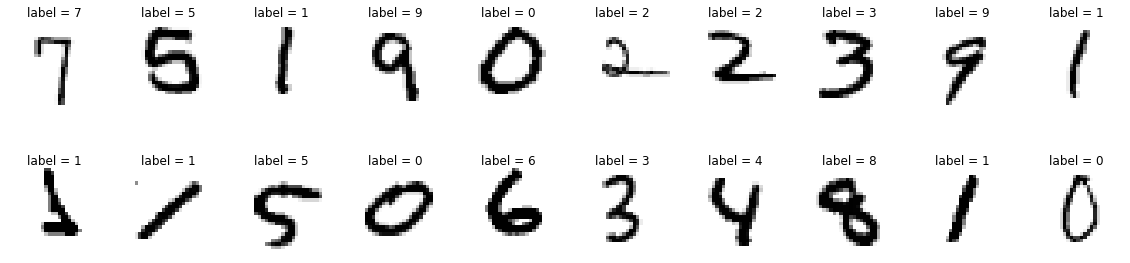

In [8]:
i = 50
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(train_images[IMGNO].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.title("label = %d" % train_labels[IMGNO],y=0.9)
    plt.axis('off')

In [20]:
train_labels.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

In [21]:
train_images = train_images.reshape(-1,HEIGHT,WIDTH,1)
test_images = test_images.reshape(-1,HEIGHT,WIDTH,1)

train_labels = keras.utils.to_categorical(train_labels, num_classes = NCLASSES)

In [22]:
train_labels[:3]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [23]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)

len(Y_train)

37800

## Data augmentation

In [24]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)

## Define a CNN model.


In [83]:
def cnn_model(X, mode, hparams):

#    X = keras.layers.Input(img, shape = (HEIGHT, WIDTH, 1))

    c1 = tf.layers.conv2d(inputs = X, filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation = tf.nn.relu)  # shape = (batch_size, HEIGHT, WIDTH, nfil1)

    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size = 2, strides = 2)                                              # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil1)
    
    c2 = tf.layers.conv2d(inputs = p1, filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = tf.nn.relu)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)
    
    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size = 2, strides = 2)                                                       # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

    c3 = tf.layers.conv2d(inputs = p2, filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.nn.relu)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)

    p3 = tf.layers.max_pooling2d(inputs=c3, pool_size = 2, strides = 2)     

    p3flat =  tf.reshape(tensor = p3, shape= [-1, p3.shape[1] * p3.shape[2] * p3.shape[3]])                                                                  # shape = (batch_size, HEIGHT // 4 * WIDTH // 4 * nfil2)

    h3 = tf.layers.dense(inputs = p3flat, units = 64, activation = tf.nn.relu)
    
    h3d = tf.layers.dropout(inputs = h3, rate = 0.25, training = (mode == tf.estimator.ModeKeys.TRAIN))    
    
    output = tf.layers.dense(inputs = h3d, units = NCLASSES, activation = None)
  



    return output, NCLASSES

## Define custom Estimator


In [97]:
def image_classifier(features, labels, mode, params):
    ylogits, nclasses = cnn_model(features["image"], mode, hparams)
    probabilities = tf.nn.softmax(logits = ylogits)
    class_ids = tf.cast(x = tf.argmax(input = probabilities, axis = 1), dtype = tf.uint8)

    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.reduce_mean(input_tensor = tf.nn.softmax_cross_entropy_with_logits(logits = ylogits, labels = labels))
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            train_op = tf.contrib.layers.optimize_loss(
                loss = loss, 
                global_step = tf.train.get_global_step(),
                learning_rate = params["learning_rate"], 
                optimizer = "Adam")
            eval_metric_ops = None
        else:
            train_op = None
            eval_metric_ops =  {"accuracy": tf.metrics.accuracy(labels = tf.argmax(input = labels, axis = 1), predictions = class_ids)}
    else:
        loss = None
        train_op = None
        eval_metric_ops = None
 
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = {"probabilities": probabilities, "class_ids": class_ids},
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = {"predictions": tf.estimator.export.PredictOutput({"probabilities": probabilities, "class_ids": class_ids})}
    )

### train and evaluate

In [107]:
def train_and_evaluate(output_dir, hparams, X_train, X_val, Y_train, Y_val):

    estimator = tf.estimator.Estimator(
        model_fn = image_classifier,
        model_dir = output_dir,
        params = hparams)

    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"image": X_train},
        y = Y_train,
        batch_size = hparams['batch_size'],
        num_epochs = hparams['epochs'],
        shuffle = True,
        queue_capacity = 5000
    )

    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"image": X_val},
        y = Y_val,
        batch_size = hparams['batch_size'],
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 5000 #TODO   
    )
    
 
    estimator.train(input_fn=train_input_fn)
    
    eval_results = estimator.evaluate(input_fn=eval_input_fn)
    
    

#   
#    exporter = tf.estimator.LatestExporter(name = "exporter", serving_input_receiver_fn = serving_input_fn)
#
#    tf.estimator.train_and_evaluate(estimator = estimator, train_spec = train_spec, eval_spec = eval_spec)


### Input functions for training, evaluation, and predicition.

In [86]:
def serving_input_fn():

    feature_placeholders = {"image": tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])}

    features = {"image": tf.expand_dims(input = feature_placeholders["image"], axis = -1)} 
    return tf.estimator.export.ServingInputReceiver(features =  features, receiver_tensors =  feature_placeholders)

## train locally


In [106]:
np.shape(X_train)

(37800, 28, 28, 1)

In [108]:
OUTDIR = "mnist\learned_v01"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time


hparams = {"epochs": 20, "batch_size": 100, "learning_rate": 0.001, "batch_norm":0 }

train_and_evaluate(OUTDIR, hparams, X_train, X_val, Y_train, Y_val)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist\\learned_v01', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002B3B9F45710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Gr

INFO:tensorflow:global_step/sec: 4.32707
INFO:tensorflow:loss = 0.002817909593529288, step = 6301 (23.110 sec)
INFO:tensorflow:global_step/sec: 4.30441
INFO:tensorflow:loss = 0.006067895172329359, step = 6401 (23.232 sec)
INFO:tensorflow:global_step/sec: 4.35172
INFO:tensorflow:loss = 0.03700321425976821, step = 6501 (23.104 sec)
INFO:tensorflow:global_step/sec: 4.33558
INFO:tensorflow:loss = 0.003922270476733641, step = 6601 (22.956 sec)
INFO:tensorflow:global_step/sec: 4.24893
INFO:tensorflow:loss = 0.0022308099459639966, step = 6701 (23.520 sec)
INFO:tensorflow:global_step/sec: 4.34409
INFO:tensorflow:loss = 0.001628934294351483, step = 6801 (23.020 sec)
INFO:tensorflow:global_step/sec: 4.29003
INFO:tensorflow:loss = 0.0005183712579832563, step = 6901 (23.310 sec)
INFO:tensorflow:global_step/sec: 4.34455
INFO:tensorflow:loss = 0.013769718755822023, step = 7001 (23.017 sec)
INFO:tensorflow:global_step/sec: 4.29143
INFO:tensorflow:loss = 0.004793686259274579, step = 7101 (23.334 sec)


local training successful, acc = 0.99

<h2 id="Next-steps">Next steps</h2>

<ol>
	<li>impletment prediction, collect log info</li>
	<li>data augmentation and learning rate</li>
	<li>create GCP training files</li>
	<li>ensemble method</li>
	<li>TF2</li>
</ol>

<h2 id=" ">credits</h2>

<p><a href="https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/08_image/mnistmodel/trainer/model.py" target="_blank">https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/08_image/mnistmodel/trainer/model.py</a></p>

<p><a href="https://www.tensorflow.org/tutorials/estimators/cnn" target="_blank">https://www.tensorflow.org/tutorials/estimators/cnn</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>
